<a href="https://colab.research.google.com/github/Neruoy/Vision-based-robotic-grasping-system-using-deep-learning/blob/main/transfer_model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Check the GPU

In [1]:
!nvidia-smi

Wed Jun  2 21:34:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Set Environment

## Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

## Get data and data prepocessing

### Unzip the dataset

In [3]:
!rm -rf /content/train_600

In [4]:
!rm -rf /content/__MACOSX

In [5]:
!unzip /content/drive/MyDrive/DLOD/train_600.zip

Archive:  /content/drive/MyDrive/DLOD/train_600.zip
   creating: train_600/
  inflating: train_600/.DS_Store     
  inflating: __MACOSX/train_600/._.DS_Store  
   creating: train_600/train/
  inflating: __MACOSX/train_600/._train  
  inflating: train_600/train/.DS_Store  
  inflating: __MACOSX/train_600/train/._.DS_Store  
  inflating: train_600/train/file_cleaning.ipynb  
   creating: train_600/train/images/
   creating: train_600/train/.ipynb_checkpoints/
   creating: train_600/train/label_txt/
  inflating: train_600/train/images/img0143.jpg  
  inflating: __MACOSX/train_600/train/images/._img0143.jpg  
  inflating: train_600/train/images/img0625.jpg  
  inflating: __MACOSX/train_600/train/images/._img0625.jpg  
  inflating: train_600/train/images/img0631.jpg  
  inflating: __MACOSX/train_600/train/images/._img0631.jpg  
  inflating: train_600/train/images/img0157.jpg  
  inflating: __MACOSX/train_600/train/images/._img0157.jpg  
  inflating: train_600/train/images/img0619.jpg  
  in

### Specify the pathes

In [6]:
train_set_folder = '/content/train_600/train'
train_images_folder = os.path.join(train_set_folder, 'images')
train_label_txt_folder = os.path.join(train_set_folder, 'label_txt')
# train_label_xml_folder = os.path.join(train_set_folder, 'label_xml')

# valid_set_folder = '/content/dataset/dev'
# vaild_images_folder = os.path.join(train_set_folder, 'images')
# vaild_label_txt_folder = os.path.join(train_set_folder, 'label_txt')
# vaild_label_xml_folder = os.path.join(train_set_folder, 'label_xml')

# test_set_folder = '/content/dataset/test'
# test_images_folder = os.path.join(train_set_folder, 'images')
# test_label_txt_folder = os.path.join(train_set_folder, 'label_txt')
# test_label_xml_folder = os.path.join(train_set_folder, 'label_xml')

### Get train images and labels

In [7]:
import random
train_images_paths = [os.path.join(train_images_folder, image) for image in os.listdir(train_images_folder)]
random.shuffle(train_images_paths)

In [8]:
def image_path2label_path(path, label_type='txt'):
  if label_type == 'txt':
    label_path = os.path.join(train_label_txt_folder, os.path.basename(path).replace('jpg', 'txt'))
  elif label_type == 'xml':
    label_path = os.path.join(train_label_xml_folder, os.path.basename(path).replace('jpg', 'xml'))
    pass
  else:
    raise Exception('No such label type')
  return label_path

def label_path2label(path, label_type='txt'):
  if label_type == 'txt':
    return np.loadtxt(path)[:4].ravel()

In [9]:
train_images_paths.remove('/content/train_600/train/images/.DS_Store')

In [10]:
train_label_paths = [image_path2label_path(img_path) for img_path in train_images_paths]

In [11]:
train_label_paths[-5:]

['/content/train_600/train/label_txt/img0929.txt',
 '/content/train_600/train/label_txt/img0111.txt',
 '/content/train_600/train/label_txt/img0467.txt',
 '/content/train_600/train/label_txt/img0534.txt',
 '/content/train_600/train/label_txt/img0950.txt']

In [12]:
train_images_paths[-5:]

['/content/train_600/train/images/img0929.jpg',
 '/content/train_600/train/images/img0111.jpg',
 '/content/train_600/train/images/img0467.jpg',
 '/content/train_600/train/images/img0534.jpg',
 '/content/train_600/train/images/img0950.jpg']

In [13]:
img = plt.imread(train_images_paths[0])
(HEIGHT, WIDTH, CHANNEL) = img.shape

In [14]:
train_labels = [label_path2label(lab_path) for lab_path in train_label_paths]

In [15]:
m = len(train_labels)
m

634

In [16]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [17]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [18]:
def preprocess_label(label):
  return label / np.array([HEIGHT, WIDTH] * 4)

In [19]:
def rescale_label(label):
  return label * np.array([HEIGHT, WIDTH] * 4)

In [20]:
def draw_box(image_path, label):
  pt = {}
  for j, i in enumerate(range(0, 8, 2)):
    pt[j + 1] = (int(label[i:i + 1][0]), int(label[i + 1:i + 2][0]))
  img = plt.imread(image_path)
  cv2.line(img, pt[1], pt[2], (0,0,255), 3)
  cv2.line(img, pt[2], pt[3], (0,0,255), 3)
  cv2.line(img, pt[3], pt[4], (0,0,255), 3)
  cv2.line(img, pt[4], pt[1], (0,0,255), 3)
  plt.imshow(img)

### Have a peek

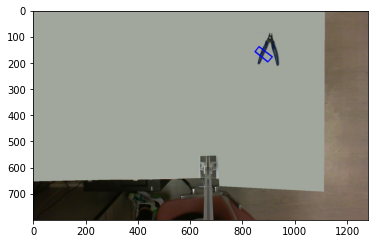

In [21]:
test_img_path, test_lab = train_images_paths[15], train_labels[15]
draw_box(test_img_path, test_lab)

## Construct the tf dataset

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

In [23]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_images_paths)

In [24]:
train_img_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_img_ds

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

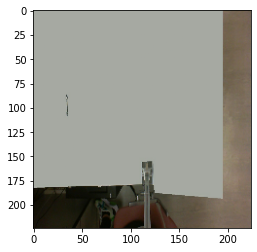

In [25]:
for item in train_img_ds.take(1):
  plt.imshow(item)

In [26]:
train_img_arr = np.array([item for item in train_img_ds])

In [27]:
train_img_arr.shape

(634, 224, 224, 3)

In [28]:
train_label_ds = tf.data.Dataset.from_tensor_slices(train_labels)
train_label_ds = train_label_ds.map(preprocess_label, num_parallel_calls=AUTOTUNE)

In [29]:
train_label_arr = np.array([item for item in train_label_ds])

In [30]:
train_label_arr.shape

(634, 8)

In [31]:
train_ds = tf.data.Dataset.zip((train_img_ds, train_label_ds))

In [32]:
valid_ds = train_ds.take(20)
train_ds = train_ds.skip(20)

## Set prefetch batch

In [33]:
BATCH_SIZE = 32

train_ds = train_ds.shuffle(buffer_size=m)
train_ds = train_ds.repeat() # repeat forever
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 8)), types: (tf.float32, tf.float64)>

In [34]:
valid_ds = valid_ds.shuffle(buffer_size=m)
valid_ds = valid_ds.repeat() # repeat forever
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 8)), types: (tf.float32, tf.float64)>

# Construct Model

In [35]:
base_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3),
                                         include_top=False, weights='imagenet')

In [36]:
base_model.trainable = False

In [37]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_1 = tf.keras.layers.Dense(2048, activation='selu', kernel_initializer='lecun_normal')
hidden_2 = tf.keras.layers.Dense(1024, activation='selu', kernel_initializer='lecun_normal')
hidden_3 = tf.keras.layers.Dense(256, activation='selu', kernel_initializer='lecun_normal')
prediction_layer = tf.keras.layers.Dense(8)

In [39]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_1(x)
x = tf.keras.layers.AlphaDropout(0.2)(x)
x = hidden_2(x)
x = tf.keras.layers.AlphaDropout(0.2)(x)
x = hidden_3(x)
x = tf.keras.layers.AlphaDropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1050624   
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              209817

In [41]:
initial_lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=initial_lr), loss='mse')

# Train the model


In [42]:
steps_per_epoch=tf.math.ceil(m/BATCH_SIZE).numpy()
steps_per_epoch

20.0

In [43]:
steps_per_valid_epoch=tf.math.ceil(20/BATCH_SIZE).numpy()
steps_per_valid_epoch

1.0

In [44]:
run_index = 1
run_logdir = os.path.join(os.curdir, "logs", "run_{:03d}".format(run_index))
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
initial_epochs = 30
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_transfer_learning.h5', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_img_arr,
                    train_label_arr, 
                    epochs=initial_epochs, 
                    validation_split=0.2,
                    # validation_data=valid_ds,
                    # validation_steps=steps_per_epoch,
                    # steps_per_epoch=steps_per_epoch,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/30
16/16 [==============================] - 13s 495ms/step - loss: 2.8373 - val_loss: 0.2858
Epoch 2/30
16/16 [==============================] - 2s 97ms/step - loss: 0.3988 - val_loss: 0.2933
Epoch 3/30
16/16 [==============================] - 2s 97ms/step - loss: 0.1785 - val_loss: 0.1437
Epoch 4/30
16/16 [==============================] - 2s 97ms/step - loss: 0.1213 - val_loss: 0.1691
Epoch 5/30
16/16 [==============================] - 2s 97ms/step - loss: 0.0940 - val_loss: 0.1063
Epoch 6/30
16/16 [==============================] - 2s 97ms/step - loss: 0.0816 - val_loss: 0.0863
Epoch 7/30
16/16 [==============================] - 2s 97ms/step - loss: 0.0747 - val_loss: 0.0852
Epoch 8/30
16/16 [==============================] - 2s 97ms/step - loss: 0.0756 - val_loss: 0.1115
Epoch 9/30
16/16 [==============================] - 2s 97ms/step - loss: 0.0744 - val_loss: 0.1211
Epoch 10/30
16/16 [==============================] - 2s 97ms/step - loss: 0.0729 - val_loss: 0.1164
Epoch 1

In [45]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [46]:
fine_tune_at = 17
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [47]:
model.compile(loss='mse',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_lr/10))

In [49]:
fine_tune_epochs = 5000
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_img_arr,
                         train_label_arr, 
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_split=0.2,
                         callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 17/5030
16/16 [==============================] - 4s 151ms/step - loss: 0.0722 - val_loss: 0.1025
Epoch 18/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0705 - val_loss: 0.0694
Epoch 19/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0415 - val_loss: 0.0563
Epoch 20/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0312 - val_loss: 0.1127
Epoch 21/5030
16/16 [==============================] - 2s 111ms/step - loss: 0.0355 - val_loss: 0.0385
Epoch 22/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0302 - val_loss: 0.0380
Epoch 23/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0295 - val_loss: 0.0540
Epoch 24/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0250 - val_loss: 0.0619
Epoch 25/5030
16/16 [==============================] - 2s 110ms/step - loss: 0.0269 - val_loss: 0.0568
Epoch 26/5030
16/16 [==============================] - 2s 110ms/step - lo